<a href="https://colab.research.google.com/github/onejbsmith/ExportedData/blob/main/Seq2Seq_LSTM_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2: Seq2Seq LSTM Model with Luong Attention

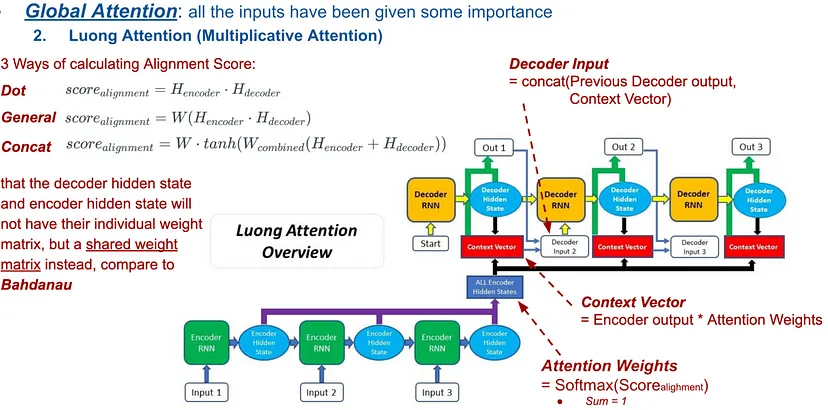

#Run the Simple Seq2Seq LSTM as ***PREREQUISITE***